# matchms tutorial
## part II - compute spectra similarities using Spec2Vec
The first part of the notebook is identical to part I (same data, same processing).

### Requirements
For this notebook to work, both `matchms` and `Spec2Vec` need to be installed.
This can be done by running:

```
conda create --name spec2vec python=3.8
conda activate spec2vec
conda install --channel nlesc --channel bioconda --channel conda-forge spec2vec
```

## Import data
- matchms has several importing options, e.g.: `load_from_json`, `load_from_mzml`, `load_from_mzxml` etc. Here we are going to use `load_from_mgf`
- Import spectrum from mgf file downloaded from GNPS (https://gnps-external.ucsd.edu/gnpslibrary, here using `GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf`)

In [1]:
import os
import numpy as np
from matchms.importing import load_from_mgf

path_data = os.path.join(os.path.dirname(os.getcwd()), "data") #"..." enter your pathname to the downloaded file
file_mgf = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf")
spectrums = list(load_from_mgf(file_mgf))

In [2]:
print(f"{len(spectrums)} spectrums found and imported")

1267 spectrums found and imported


## Inspect spectra
- Inspect the metadata: inchikey, inchi, smiles
- Inspect the number of peaks per spectrum

In [3]:
inchikeys = [s.get("inchikey") for s in spectrums]
found_inchikeys = np.sum([1 for x in inchikeys if x is not None])
print(f"Found {int(found_inchikeys)} inchikeys in metadata")

Found 0 inchikeys in metadata


In [4]:
inchi = [s.get("inchi") for s in spectrums]
inchi[:10]

['N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A']

In [5]:
smiles = [s.get("smiles") for s in spectrums]
smiles[:10]

['OC(=O)[C@H](NC(=O)CCN1C(=O)[C@@H]2Cc3ccccc3CN2C1=O)c4ccccc4',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COc1cc(O)c2c(=O)cc(oc2c1)c3ccccc3',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(CC=C)C4=O',
 'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1c(Cc2ccccc2)c(=O)oc3c(C)c(OCC(=O)N[C@@H](Cc4ccccc4)C(=O)O)ccc13',
 'CC(Cc1c[nH]c2ccccc12)C(=O)O',
 'COc1ccc(CNC(=O)[C@@H](NC(=O)C2CCN(CC2)C(=O)[C@@H](N)CC(C)C)C(C)C)cc1',
 'Cc1c(Br)c(=O)oc2cc(OCC(=O)N3C[C@H]4C[C@@H](C3)c5cccc(=O)n5C4)ccc12']

In [6]:
from matchms.filtering import default_filters
from matchms.filtering import repair_inchi_inchikey_smiles
from matchms.filtering import derive_inchikey_from_inchi
from matchms.filtering import derive_smiles_from_inchi
from matchms.filtering import derive_inchi_from_smiles
from matchms.filtering import harmonize_undefined_inchi
from matchms.filtering import harmonize_undefined_inchikey
from matchms.filtering import harmonize_undefined_smiles
from matchms.filtering import add_precursor_mz

def metadata_processing(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = repair_inchi_inchikey_smiles(spectrum)
    spectrum = derive_inchi_from_smiles(spectrum)
    spectrum = derive_smiles_from_inchi(spectrum)
    spectrum = derive_inchikey_from_inchi(spectrum)
    spectrum = harmonize_undefined_smiles(spectrum)
    spectrum = harmonize_undefined_inchi(spectrum)
    spectrum = harmonize_undefined_inchikey(spectrum)
    spectrum = add_precursor_mz(spectrum)
    return spectrum

In [7]:
spectrums = [metadata_processing(s) for s in spectrums]

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2R)-2-[3-[(10aS)-1,3-dioxo-10,10a-dihydro-5H-imidazo[1,5-b]isoquinolin-2-yl]propanoylamino]-2-phenylacetic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-3-benzoyl-2,7b-dihydro-1aH-oxireno[2,3-c]quinoline-2-carbonitrile"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 5-hydroxy-7-methoxy-2-phenylchromen-4-one
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-[2-[7-methoxy-6-[(Z)-(2,4,6-trioxo-1-prop-2-enyl-1,3-diazinan-5-ylidene)methyl]-1,3-benzodioxol-5-yl]ethyl]-N-methylbenzamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-2-[[(2S)-3-methyl-2-[[(2S)-3-oxo-2-propan-2-yl-2,4-dihydroquinoxaline-1-carbonyl]amino]butanoyl]amino]-3-phenylpropanoic acid"
Removed adduct M+H fr

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 6-hydroxy-2-(4-methoxyphenyl)chromen-4-one
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[(E)-6,7-dihydroxy-3,7-dimethyloct-2-enoxy]-1H-quinolin-2-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(5-hydroxy-1H-indol-3-yl)-2-[2-(4-methyl-6-oxobenzo[c]chromen-3-yl)oxypropanoylamino]propanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[2-(3,4-dimethyl-2-oxochromen-7-yl)oxyacetyl]piperidine-4-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from 

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2,2-diphenylacetic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(4-chlorophenyl)-2-[[2-[(7-methyl-4-oxo-2,3-dihydro-1H-cyclopenta[c]chromen-9-yl)oxy]acetyl]amino]propanoic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-(2-hydroxy-5-prop-2-enylphenyl)-4-prop-2-enylphenol
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-[[2-(4-butyl-7-methyl-2-oxochromen-5-yl)oxyacetyl]amino]-3-(4-chlorophenyl)propanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-[(E)-3-(3,4-dihydroxyphenyl)prop-2-enoyl]-2-hydroxybenzamide"
Removed adduct M+H from compound name.
Added adduct M+H to m

Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+Na from compound name.
Added adduct M+Na to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 5,7-dimethoxy-4-phenylchromen-2-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[(2S)-2-amino-4-methylsulfanylbutanoyl]-N-[(2S)-1-[(4-methoxyphenyl)methylamino]-3-methyl-1-oxobutan-2-yl]piperidine-4-carboxamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (E)-3-(4-hydroxyphenyl)-1-(2,4,6-trihydroxyphenyl)prop-2-en-1-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Ad

Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2R)-1-[(2S)-2-[[(2S)-2-(2,4-dioxo-1H-quinazolin-3-yl)-3-phenylpropanoyl]amino]-3-methylpentanoyl]pyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-(3-imidazol-1-ylpropyl)-2-[4-(4-methoxyphenyl)-2-oxochromen-7-yl]oxyacetamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-hydroxy-6-(4-hydroxy-2-methoxy-6-methoxycarbonylphenoxy)-4-methylbenzoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (4R,4aS,8aS)-4-hydroxy-4-(hydroxymethyl)-3,4a,8,8-tetramethyl-5,6,7,8a-tetrahydronaphthalen-1-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-[(2S)-1-[(4-fluorophenyl)methylamino]-3-methyl-1-oxobutan-2-yl]-1-[(2S)-pyrrolidine-2-carbonyl]piperidine-4-carboxamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-cyclopropyl-3-(2,3,5-trimethyl-7-oxofuro[3,2-g]chromen-6-yl)propanamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[[[2-(2-oxo-3-phenylchromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from c

Added cleaned compound name: (2R)-3-(1H-indol-3-yl)-2-[[(2S)-4-methyl-2-[(3-oxo-2,4-dihydroquinoxaline-1-carbonyl)amino]pentanoyl]amino]propanoic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-(pyridin-2-ylmethyl)-2-[(4,8,8-trimethyl-2-oxo-9,10-dihydropyrano[2,3-h]chromen-5-yl)oxy]acetamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-2-[[2-[(3-oxo-2,4-dihydroquinoxaline-1-carbonyl)amino]acetyl]amino]-3-phenylpropanoic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[[[2-[(8,8-dimethyl-2-oxo-4-propyl-9,10-dihydropyrano[2,3-h]chromen-5-yl)oxy]acetyl]amino]methyl]cyclohexane-1-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[2-[(7-methyl-4-oxo-2,3-di

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-3-(1H-indol-3-yl)-2-[2-(7-methyl-2-oxo-4-propylchromen-5-yl)oxypropanoylamino]propanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: methyl quinoline-2-carboxylate
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-1-[3-[(10aS)-1,3-dioxo-10,10a-dihydro-5H-imidazo[1,5-b]isoquinolin-2-yl]propanoyl]pyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: tert-butyl (2S)-2-[4-[[(2S)-1-[(2-methoxyphenyl)methylamino]-1-oxopropan-2-yl]carbamoyl]piperidine-1-carbonyl]pyrrolidine-1-carboxylate
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-(3,4-dimethoxyphenyl)-3,5,7-trimethoxychromen-4-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Add

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (3S)-N-[(2S)-3-(1H-indol-3-yl)-1-(3-methylanilino)-1-oxopropan-2-yl]-1,2,3,4-tetrahydroisoquinoline-3-carboxamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-pyridin-3-yl-2-[(3,4,8,8-tetramethyl-2-oxo-9,10-dihydropyrano[2,3-h]chromen-5-yl)oxy]acetamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1,11,22-trihydroxy-1,6,11,16,22,27-hexazacyclodotriacontane-2,5,12,15,23,26-hexone"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2R)-2-[[2-[(3-oxo-2,4-dihydroquinoxaline-1-carbonyl)amino]acetyl]amino]-3-phenylpropanoic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: [6-methoxy-2-oxo-

Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-2-[[1-[(2S)-4-methyl-2-[(4-methylphenyl)sulfonylamino]pentanoyl]piperidine-4-carbonyl]amino]-3-phenylpropanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(5-hydroxy-1H-indol-3-yl)-2-[2-(2-oxo-4-phenylchromen-7-yl)oxypropanoylamino]propanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(3,5-dimethyl-7-oxofuro[3,2-g]chromen-6-yl)-N-(2-morpholin-4-yl

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[(2S)-2-amino-4-methylpentanoyl]-N-[(2S)-1-[(4-methylphenyl)methylamino]-1-oxopropan-2-yl]piperidine-4-carboxamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[2-(4,8-dimethyl-2-oxochromen-7-yl)oxyacetyl]piperidine-4-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-1-[2-[[(2Z)-2-[(3,4-dimethoxyphenyl)methylidene]-3-oxo-1-benzofuran-6-yl]oxy]acetyl]-4-hydroxypyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(4-chlorophenyl)-2-[[2-(8-methyl-2-oxo-4-phenylchromen-7-yl)oxyacetyl]amino]propanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound 

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-[[2-(3-benzyl-4-methyl-2-oxochromen-7-yl)oxyacetyl]amino]-3-(4-chlorophenyl)propanoic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (E)-3-(4-hydroxyphenyl)-1-(4-methoxyphenyl)prop-2-en-1-one
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 7-methoxy-8-(3-methyl-2-oxobutyl)chromen-2-one
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-[(5-hydroxy-2,2-dimethyl-4-oxo-3H-chromen-7-yl)oxy]-N-[(4-methoxyphenyl)methyl]acetamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[2-(4-ethyl-2-oxochromen-7-yl)oxyacetyl]piperidine-4-carboxamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M

Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[[[2-(4,8-dimethyl-2-oxochromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[(2S)-2-[[(2S)-2-(2,4-dioxo-1H-quinazolin-3-yl)-3-phenylpropanoyl]amino]-3-methylpentanoyl]piperidine-4-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2Z)-2-[(3,4-dihydroxyphenyl)methylidene]-6-hydroxy-1-benzofuran-3-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 5,7-dihydroxy-2-(4-hydroxyphenyl)-3-methoxychromen-4-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-[3-(2-oxopyrrolidin-1-yl)propyl]-

Added cleaned compound name: 4,9-bis(3-methylbut-2-enoxy)furo[3,2-g]chromen-7-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[2-[(4-methyl-6-oxo-7,8,9,10-tetrahydrobenzo[c]chromen-3-yl)oxy]acetyl]piperidine-4-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[[[2-(6-chloro-2-oxo-4-phenylchromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2R)-2-[6-(1,2-dihydroimidazo[1,2-a]benzimidazole-3-carbonylamino)hexanoylamino]-3-phenylpropanoic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: methyl 2-benzamidoacetate
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 5-hydroxy-2,2-dimethyl-7-[2-oxo-2-(4-phenylpiperazin-1-yl)ethoxy]-3H-chromen-4-one"
Removed addu

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-1-benzoyl-3,4-dihydroxy-3,4-dihydro-2H-quinoline-2-carbonitrile"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (3S)-N-[(2S)-1-(3,5-dimethylanilino)-3-(1H-indol-3-yl)-1-oxopropan-2-yl]-1,2,3,4-tetrahydroisoquinoline-3-carboxamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(3,5-dimethyl-7-oxofuro[3,2-g]chromen-6-yl)-N-(3-imidazol-1-ylpropyl)propanamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-[4-(4-methoxyphenyl)-2-oxochromen-7-

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-[(5-hydroxy-2,2-dimethyl-4-oxo-3H-chromen-7-yl)oxy]-N-(4-sulfamoylphenyl)acetamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(3,4-dihydroxyphenyl)-6,8-dihydroxyisochromen-1-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-imino-1-[(4-methoxyphenyl)methyl]-5-oxo-N-(oxolan-2-ylmethyl)dipyrido[1,2-d:3',4'-f]pyrimidine-3-carboxamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-[(2S)-3-methyl-1-[(4-methylphenyl)methylamino]-1-oxobuta

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-1-[2-[[(2Z)-2-[(2,4-dimethoxyphenyl)methylidene]-3-oxo-1-benzofuran-6-yl]oxy]acetyl]pyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[[2-(6-ethyl-2-oxo-4-phenylchromen-7-yl)oxypropanoylamino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: N-(2-hydroxy-2-phenylethyl)-2-[(3,4,8,8-tetramethyl-2-oxo-9,10-dihydropyrano[2,3-h]chromen-5-yl)oxy]acetamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-N-(2-ethylphenyl)-5-oxo-1-(3-oxo-1H-2-benzofuran-1-yl)pyrrolidine-2-carboxami

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S,3S,3aR)-2-(1,3-benzodioxol-5-yl)-5,7-dimethoxy-3-methyl-3a-prop-2-enyl-2,3-dihydro-1-benzofuran-6-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 4-[[2-(2-oxo-4-propylchromen-7-yl)oxypropanoylamino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-[(4-ethyl-8,8-dimethyl-2-oxo-9,10-dihydropyrano[2,3-h]chromen-5-yl)oxy]-N-(2-morpholin-4-ylethyl)acetamide"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 2-(3,4-dimethoxyphenyl)-5-hydroxy-3,6,7,8-tetramethoxychromen-4-one"
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-(5-hydroxy-1H-indol-3-yl)-2-[[2-(3

Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: tert-butyl N-[(2S)-1-[4-[[(2S)-1-[(4-methoxyphenyl)methylamino]-1-oxopropan-2-yl]carbamoyl]piperidin-1-yl]-4-methylsulfanyl-1-oxobutan-2-yl]carbamate
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 3-methoxybenzo[c]chromen-6-one
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1-[(2S)-2-amino-4-methylsulfanylbutanoyl]-N-[(2R)-1-[(4-methoxyphenyl)methylamino]-1-oxopropan-2-yl]piperidine-4-carboxamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: 1H-indole-3-carboxamide
Removed adduct M+H from compound name.
Added adduct M+H to metadata.
Added cleaned compound name: (2S)-2-[[(2S)-2-[[(2S)-2-(2,4-dioxo-1H-quinazolin-3-yl)-3-phenylpropanoyl]amino]-

In [8]:
inchi = [s.get("inchi") for s in spectrums]
inchi[:10]

['InChI=1S/C22H21N3O5/c26-18(23-19(21(28)29)14-6-2-1-3-7-14)10-11-24-20(27)17-12-15-8-4-5-9-16(15)13-25(17)22(24)30/h1-9,17,19H,10-13H2,(H,23,26)(H,28,29)/t17-,19+/m0/s1',
 'InChI=1S/C17H12N2O2/c18-10-14-16-15(21-16)12-8-4-5-9-13(12)19(14)17(20)11-6-2-1-3-7-11/h1-9,14-16H/t14-,15?,16?/m0/s1',
 'InChI=1S/C16H12O4/c1-19-11-7-12(17)16-13(18)9-14(20-15(16)8-11)10-5-3-2-4-6-10/h2-9,17H,1H3',
 'InChI=1S/C26H25N3O7/c1-4-11-29-25(32)19(23(30)27-26(29)33)14-18-17(13-20-22(21(18)34-3)36-15-35-20)10-12-28(2)24(31)16-8-6-5-7-9-16/h4-9,13-14H,1,10-12,15H2,2-3H3,(H,27,30,33)/b19-14-',
 'InChI=1S/C26H32N4O5/c1-15(2)21(23(31)28-19(25(33)34)14-17-10-6-5-7-11-17)29-26(35)30-20-13-9-8-12-18(20)27-24(32)22(30)16(3)4/h5-13,15-16,19,21-22H,14H2,1-4H3,(H,27,32)(H,28,31)(H,29,35)(H,33,34)/t19-,21-,22-/m0/s1',
 'InChI=1S/C19H20O7/c20-15(11-25-18(23)13-7-3-1-4-8-13)17(22)16(21)12-26-19(24)14-9-5-2-6-10-14/h1-10,15-17,20-22H,11-12H2',
 'InChI=1S/C29H27NO6/c1-18-22-13-14-25(19(2)27(22)36-29(34)23(18)15-20-9-5-3-6

In [9]:
inchikeys = [s.get("inchikey") for s in spectrums]
inchikeys[:10]

['XTJNPXYDTGJZSA-PKOBYXMFSA-N',
 'VOYWJNWCKFCMPN-FHERZECASA-N',
 'IRZVHDLBAYNPCT-UHFFFAOYSA-N',
 'OPWCHZIQXUKNMP-RGEXLXHISA-N',
 'GTBYYVAKXYVRHX-BVSLBCMMSA-N',
 'UVZWLAGDMMCHPD-UHFFFAOYSA-N',
 'XKWILXCQJFNUJH-DEOSSOPVSA-N',
 'JDZNIWUNOASRIK-UHFFFAOYSA-N',
 'RCAVVTTVAJETSK-VXKWHMMOSA-N',
 'KQAZJQXFNDOORW-CABCVRRESA-N']

Text(0, 0.5, 'Number of spectra')

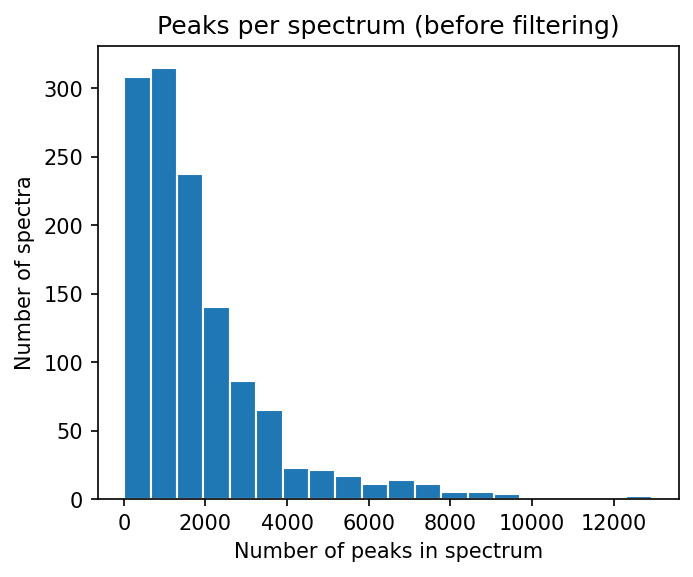

In [10]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

from matplotlib import pyplot as plt
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")
#plt.savefig("hist01.png")

## Processing pipeline

In [11]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_intensity
from matchms.filtering import select_by_mz

def peak_processing(spectrum):
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_intensity(spectrum, intensity_from=0.01)
    spectrum = select_by_mz(spectrum, mz_from=10, mz_to=1000)
    return spectrum

In [12]:
spectrums = [peak_processing(s) for s in spectrums]

Text(0, 0.5, 'Number of spectra')

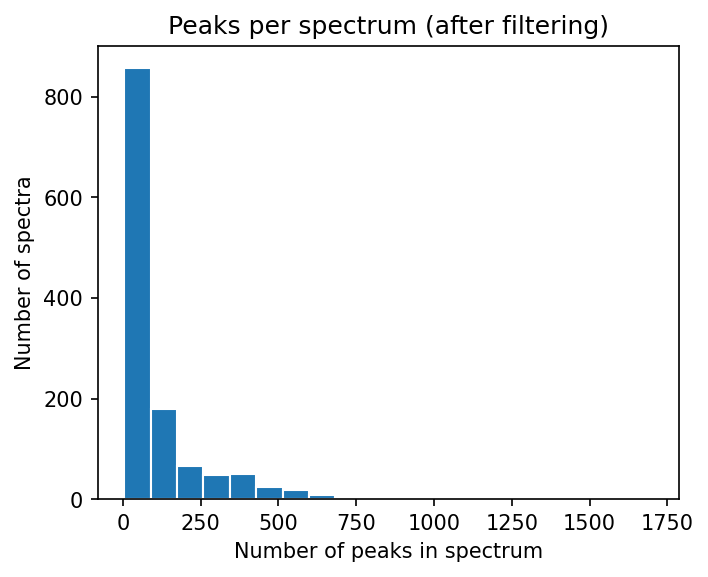

In [13]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

from matplotlib import pyplot as plt
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (after filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")
#plt.savefig("hist02.png")

- the filtering did drastically reduce the (initially very high) number of peaks per spectrum
- this is mostly due to the removal of peaks < 0.01 of the max intensity

---

# Spec2Vec
## Computing spectra similarities between all spectra using Spec2Vec
In the following part spectra similarities will be calculated using Spec2Vec. Spec2Vec is an unsupervised machine learning technique that can learn relationships between peaks from larger spectra datasets.

Spec2Vec can be used in two fundamentally different ways.

**(1)** A Spec2Vec model can be trained on the dataset of interest itself. This requires a sufficiently large datasets (at least several hundreds of spectra).


**(2)** Loading a Spec2Vec model which was pretrained on a large MS/MS dataset. 

We will do both things in the following part of this notebook.

## 1. Train a new Spec2Vec model from scratch

In [14]:
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model

First we create "spectrum documents" from the imported and processed spectra:

In [61]:
spectrum_documents = [SpectrumDocument(s) for s in spectrums]

In [18]:
len(spectrum_documents)

1267

Then we train a new model on the 1267 found spectra. This can take a few minutes to train.

In [20]:
model_file = "tutorial_model.model"
model = train_new_word2vec_model(spectrum_documents, iterations=[25], filename=model_file,
                                 workers=2, progress_logger=True)

The value of workers is set from 4 (default) to 2
  Epoch 1 of 25.Change in loss after epoch 1: 211605.921875
  Epoch 2 of 25.Change in loss after epoch 2: 172194.421875
  Epoch 3 of 25.Change in loss after epoch 3: 165664.34375
  Epoch 4 of 25.Change in loss after epoch 4: 160644.75
  Epoch 5 of 25.Change in loss after epoch 5: 157956.375
  Epoch 6 of 25.Change in loss after epoch 6: 155802.4375
  Epoch 7 of 25.Change in loss after epoch 7: 153745.25
  Epoch 8 of 25.Change in loss after epoch 8: 158220.375
  Epoch 9 of 25.Change in loss after epoch 9: 157094.0
  Epoch 10 of 25.Change in loss after epoch 10: 150534.75
  Epoch 11 of 25.Change in loss after epoch 11: 150039.0
  Epoch 12 of 25.Change in loss after epoch 12: 149719.0
  Epoch 13 of 25.Change in loss after epoch 13: 154290.125
  Epoch 14 of 25.Change in loss after epoch 14: 144850.5
  Epoch 15 of 25.Change in loss after epoch 15: 144366.25
  Epoch 16 of 25.Change in loss after epoch 16: 143403.75
  Epoch 17 of 25.Change in l

## Compute similarities

In [62]:
#optional: load the model if you trained it already before:
import gensim

model = gensim.models.Word2Vec.load("tutorial_model.model")

In [64]:
from matchms import calculate_scores
from spec2vec import Spec2Vec

spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

scores = calculate_scores(spectrum_documents, spectrum_documents, spec2vec_similarity, is_symmetric=True)

## Get highest scoring results for a spectrum of interest

In [65]:
best_matches = scores.scores_by_query(spectrum_documents[11], sort=True)[:10]
[x[1] for x in best_matches]

[1.0000000000000002,
 0.6142875528506624,
 0.6084457310887001,
 0.601431303744898,
 0.5909574775594757,
 0.5798409458568399,
 0.5117013293902793,
 0.5106301516819481,
 0.5026096813118243,
 0.4625427813425015]

In [66]:
[x[0]._obj.get("smiles") for x in best_matches]

['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](C(C)C)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CCC(=O)N)C(=O)O',
 'CCCCCC(NC(=O)C1CCN(CC1)C(=O)[C@@H](NS(=O)(=O)c2ccc(C)cc2)C(C)C)C(=O)O',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@H](C)NS(=O)(=O)c3ccc(C)cc3',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@@H](NS(=O)(=O)c3ccc(C)cc3)C(C)C',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)N']

Those smiles can be beter inspected by plotting the corresponding chemical structures, e.g. using rdkit:

In [67]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0]._obj.get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

## Visualize the results

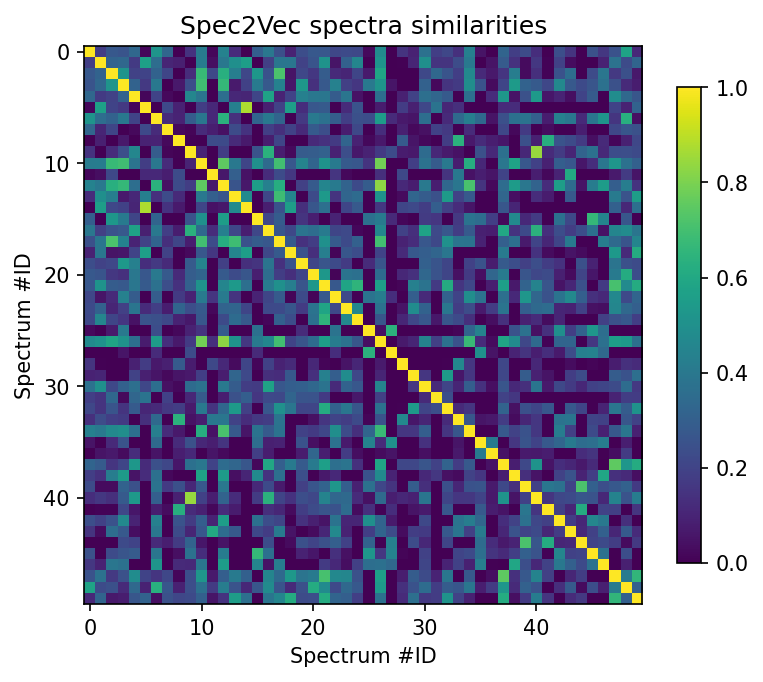

In [32]:
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores.scores[:50, :50], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Spec2Vec spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.clim(0, 1)  # Spec2Vec scores can be between -1 and 1
#plt.savefig("spec2vec_scores.png")

## 2. Load a pretrained Spec2Vec model
For many use-cases we would not advice to retrain a new model from scratch. Instead a more general model that has been trained on a large MS/MS dataset can simply be loaded and used to calculate similarities, even for spectra which were not part of the initial model training.

Here we can download a model trained on about 95,000 spectra from GNPS (positive ionmode) which we provide here: https://zenodo.org/record/4173596.

Let's now load this model:

In [68]:
import gensim

path_model = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\trained_models" #"..."
filename_model = "spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model"
filename = os.path.join(path_model, filename_model)

model = gensim.models.Word2Vec.load(filename)

It is very important to make sure that the "documents" are created the same way as for the model training. This mostly comes down here to the number of decimals which needs to be the same here than for the pretrained model. To inspect the words the model has learned, we can look at `model.wv.vocab` which is the "vocabulary" the model has learned.

In [51]:
list(model.wv.vocab.keys())[0]

'peak@289.29'

This means the model will expect words with 2 decimals!

In [69]:
spectrum_documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]

In [54]:
spectrum_documents[0].words[:10]

['peak@103.05',
 'peak@106.07',
 'peak@107.05',
 'peak@109.21',
 'peak@115.06',
 'peak@117.55',
 'peak@128.74',
 'peak@130.07',
 'peak@131.07',
 'peak@132.08']

## Compute similarities

In [70]:
from matchms import calculate_scores
from spec2vec import Spec2Vec

spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)

scores = calculate_scores(spectrum_documents, spectrum_documents, spec2vec_similarity, is_symmetric=True)

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.19%.


## Get highest scoring results for a spectrum of interest

In [71]:
best_matches = scores.scores_by_query(spectrum_documents[11], sort=True)[:10]
[x[1] for x in best_matches]

[0.9999999999999994,
 0.6323327469158129,
 0.6094968210816908,
 0.5633651650965529,
 0.532211381301199,
 0.5311480111999451,
 0.49455675109741976,
 0.48921947174118874,
 0.4697946531301545,
 0.4092511656226544]

In [72]:
[x[0]._obj.get("smiles") for x in best_matches]

['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CCCCCC(NC(=O)C1CCN(CC1)C(=O)[C@@H](NS(=O)(=O)c2ccc(C)cc2)C(C)C)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CCC(=O)N)C(=O)O',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](C(C)C)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@@H](NS(=O)(=O)c3ccc(C)cc3)C(C)C',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)N',
 'CSCC[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccc(O)cc3)C(=O)O']

In [73]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0]._obj.get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

In [108]:
best_matches = scores.scores_by_query(spectrum_documents[1085], sort=True)[:10]
[x[1] for x in best_matches]

[1.0000000000000004,
 0.5065568749612721,
 0.41948784595634114,
 0.414085763154699,
 0.39519431228898066,
 0.39343248614655296,
 0.3577234062799497,
 0.33414554433321114,
 0.32956477173520093,
 0.32765420689709646]

In [109]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0]._obj.get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

In [26]:
[x[0]._obj.get("smiles") for x in best_matches]

['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'COC(=O)CNC(=O)c1ccccc1',
 'Cc1cc(=O)oc2cc(OC(=O)c3ccccc3)ccc12',
 'COc1cc(CC=C)ccc1OC(=O)c2ccccc2',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'O=C(Nc1ccccc1OC(=O)c2ccccc2)c3ccccc3',
 'O=C(OCC1OC(C(OC(=O)c2ccccc2)C1OC(=O)c3ccccc3)n4ncc(=O)[nH]c4=O)c5ccccc5',
 'O=C(N1CCCCC1)c2ccccc2',
 'COc1ccc2ccc(=O)oc2c1',
 'Oc1ccc2c(O)cc(=O)oc2c1']

Those smiles can be beter inspected by plotting the corresponding chemical structures, e.g. using rdkit:

In [38]:
from rdkit import Chem
from rdkit.Chem import Draw

for i, smiles in enumerate([x[0]._obj.get("smiles") for x in best_matches]):
    m = Chem.MolFromSmiles(smiles)
    Draw.MolToFile(m, f"compound_{i}.png")

## Visualize the results

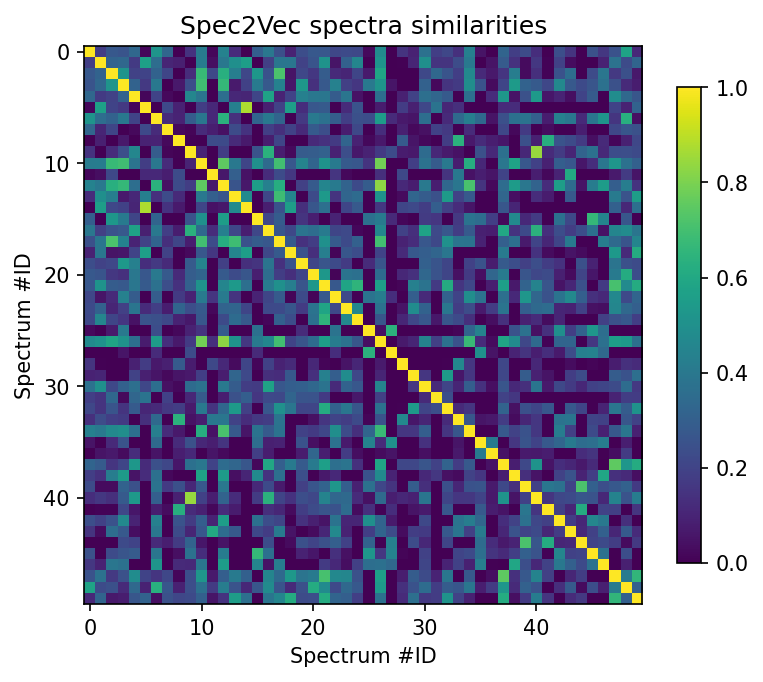

In [32]:
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores.scores[:50, :50], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Spec2Vec spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.clim(0, 1)  # Spec2Vec scores can be between -1 and 1
#plt.savefig("spec2vec_scores.png")